## CS172 Assignment 1

包佳诚2021533098

#### Problem 1: Bag-of-Words model

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.decomposition import PCA

(1) Write a function that can read an image from the dataset and display it with the corresponding label.

./animals/cats/cats_00103.jpg
cats


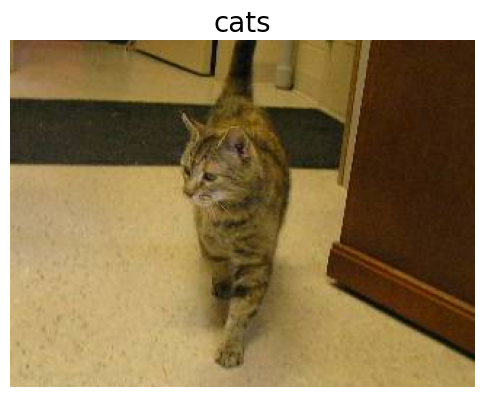

In [2]:
# path to images

path = './animals/'
# path = './animals/dogs/dogs_00001.jpg'

# animal categories
categories = ['dogs', 'panda', 'cats']

def display_image_with_label(dataset_path):
    jpg_files = []
    # if ends with jpg
    if dataset_path.endswith('.jpg'):
        jpg_files.append(dataset_path)
    else:
        #if root dir -> random choice
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.jpg'):
                    jpg_files.append(os.path.join(root, file))
    if jpg_files:
        random_file = random.choice(jpg_files)
        print(random_file)
        # get label
        parent_dir = os.path.dirname(random_file)
        category_label = os.path.basename(parent_dir)
        print(category_label)
        #read img
        img = cv2.imread(random_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(category_label,fontsize = 20)
        plt.show()
        return img
    else:
        print("jpg not exist")

img = display_image_with_label(path)

(2) Uniform image size. Select an image and apply at least two image augmentation methods (like flip, rotation, blur, mixup, etc.) to it. Show the results.

I just choose the random chosen output image in (1).

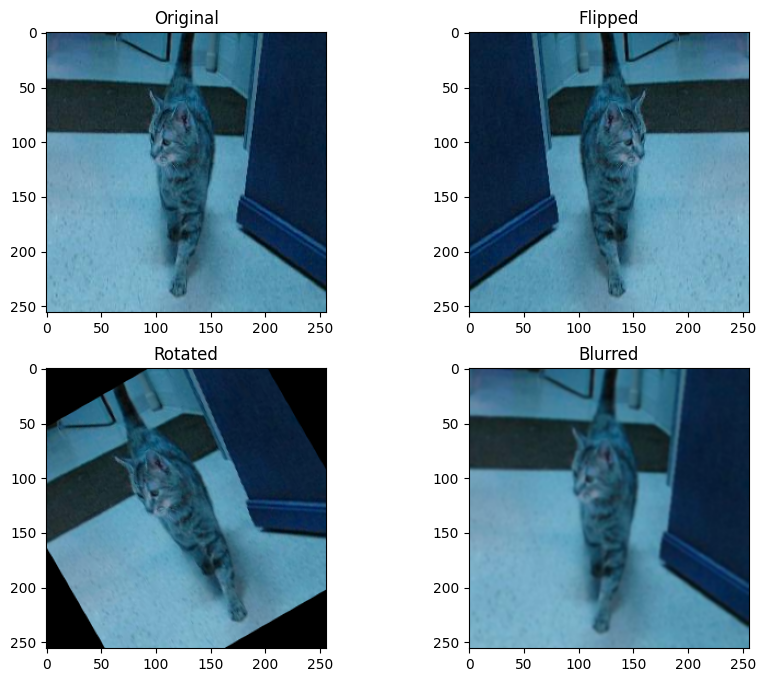

In [3]:

def uniform_img_size(img):
    target_size = (256, 256)
    return cv2.resize(img, target_size)

pro2_img = uniform_img_size(img)

# flip
flipped_image = cv2.flip(pro2_img, 1)

# rotate
rotation_angle = 30 
rows, cols, _ = pro2_img.shape
rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
rotated_image = cv2.warpAffine(pro2_img, rotation_matrix, (cols, rows))

# blur
blurred_image = cv2.GaussianBlur(pro2_img, (5, 5), 0)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(pro2_img)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(flipped_image)
axs[0, 1].set_title("Flipped")
axs[1, 0].imshow(rotated_image)
axs[1, 0].set_title("Rotated")
axs[1, 1].imshow(blurred_image)
axs[1, 1].set_title("Blurred")
plt.show()

In [4]:
# uniform all pictures
def uniform_all_pictures(dataset_path):
    jpg_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    for jpg_file in jpg_files:
        img = cv2.imread(jpg_file)
        resized_img = uniform_img_size(img)
        new_file_path = jpg_file.replace('animals', 'uniform_animals')
        os.makedirs(os.path.dirname(new_file_path), exist_ok=True)

        cv2.imwrite(new_file_path, resized_img)

uniform_all_pictures("./animals")

(3) Compute SIFT for all the images and select five pictures to visualize the results after SIFT. We suggest saving the features on disks after each iteration to avoid memory issues.

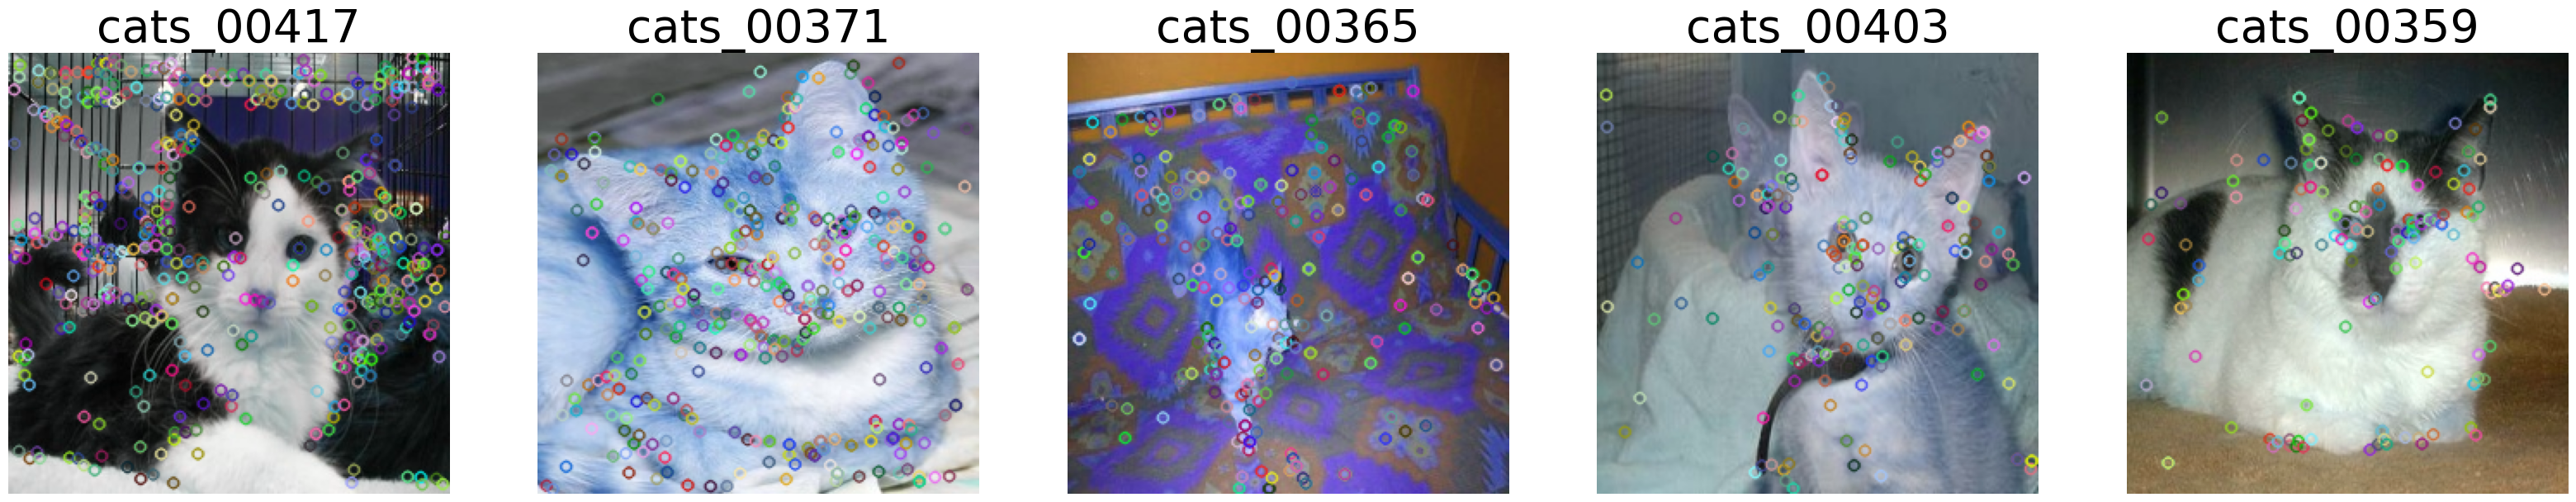

In [5]:
def calculate_visualize_sift(dataset_path, class_names):
    sift = cv2.SIFT_create()
    plt.figure(figsize=(40, 8))
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        for i, image_file in enumerate(image_files):
            # image path
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)

            # SIFT
            keypoints, descriptors = sift.detectAndCompute(image, None)
            
            # Save features
            feature_path = image_path.replace(".jpg","") + "_features.npy"
            np.save(feature_path, descriptors)

            name = os.path.basename(feature_path).replace("_features.npy", "")
            # select 5 pictures to visualize
            if i < 5 and class_name=="cats":
                plt.subplot(1,5, i+1)
                img_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
                plt.imshow(img_with_keypoints)
                plt.title(f"{name}",fontsize=40)
                plt.axis("off")


uniform_path = "./uniform_animals"
class_names = ["dogs", "cats", "panda"]
calculate_visualize_sift(uniform_path, class_names)

(4) For all the features, apply with the K-Means algorithm. Discuss the influence of different values of k on
the results.


(5) Use the BoW model to quantize features and represent by frequencies.

Answer for 4:

When the selected K value is too small, the number of clustering centers will not be enough to capture the diversity of data, resulting in underfitting. This can result in similar but not identical features being combined into the same cluster, reducing the ability of features to differentiate.(like k = 10)

On the other hand, when the selected value of K is too large, there is a problem of overfitting. Too many cluster centers may result in noisy data also being assigned to different clusters, reducing the robustness of features. In image feature clustering, if the value of K is too large, some noisy or unrelated features may be treated as separate visual words, thus introducing useless information and affecting the subsequent image representation.

In [3]:
def merge_all_features(dataset_path):
    features = []
    names = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.npy'):
                features.append(np.load(os.path.join(root, file)))
                names.append(os.path.join(root, file))
    features_merged = np.concatenate(features)
    return features, features_merged, names

features_path = "./uniform_animals"
features_arr, features_merged_arr, names = merge_all_features(features_path)
print(features_arr[0].shape)
print(features_merged_arr.shape)


(262, 128)
(1280517, 128)


In [4]:
def kmeans(features_arr, features_merged_arr, k_value):
    kmeans = KMeans(n_clusters=k_value,n_init="auto")
    kmeans.fit(features_merged_arr)
    cluster_counts = np.array([np.zeros(kmeans.n_clusters) for i in range(len(features_arr))])
    # print(cluster_counts.shape)# 3000,4
    for i, sample_features in enumerate(tqdm(features_arr, total=len(features_arr))):
        # print(sample_features.shape) #(-1,128)
        for feature_vector in sample_features:
            feature_vector = feature_vector.reshape(1, -1)
            y_pred = kmeans.predict(feature_vector)
            cluster_counts[i][y_pred] += 1
    return cluster_counts
k_values = [10, 25, 35, 40]
kmeans_cluster_counts_10 = kmeans(features_arr, features_merged_arr, k_values[0])
kmeans_cluster_counts_25 = kmeans(features_arr, features_merged_arr, k_values[1])
kmeans_cluster_counts_35 = kmeans(features_arr, features_merged_arr, k_values[2])
kmeans_cluster_counts_40 = kmeans(features_arr, features_merged_arr, k_values[3])

100%|██████████| 3000/3000 [02:12<00:00, 22.60it/s]


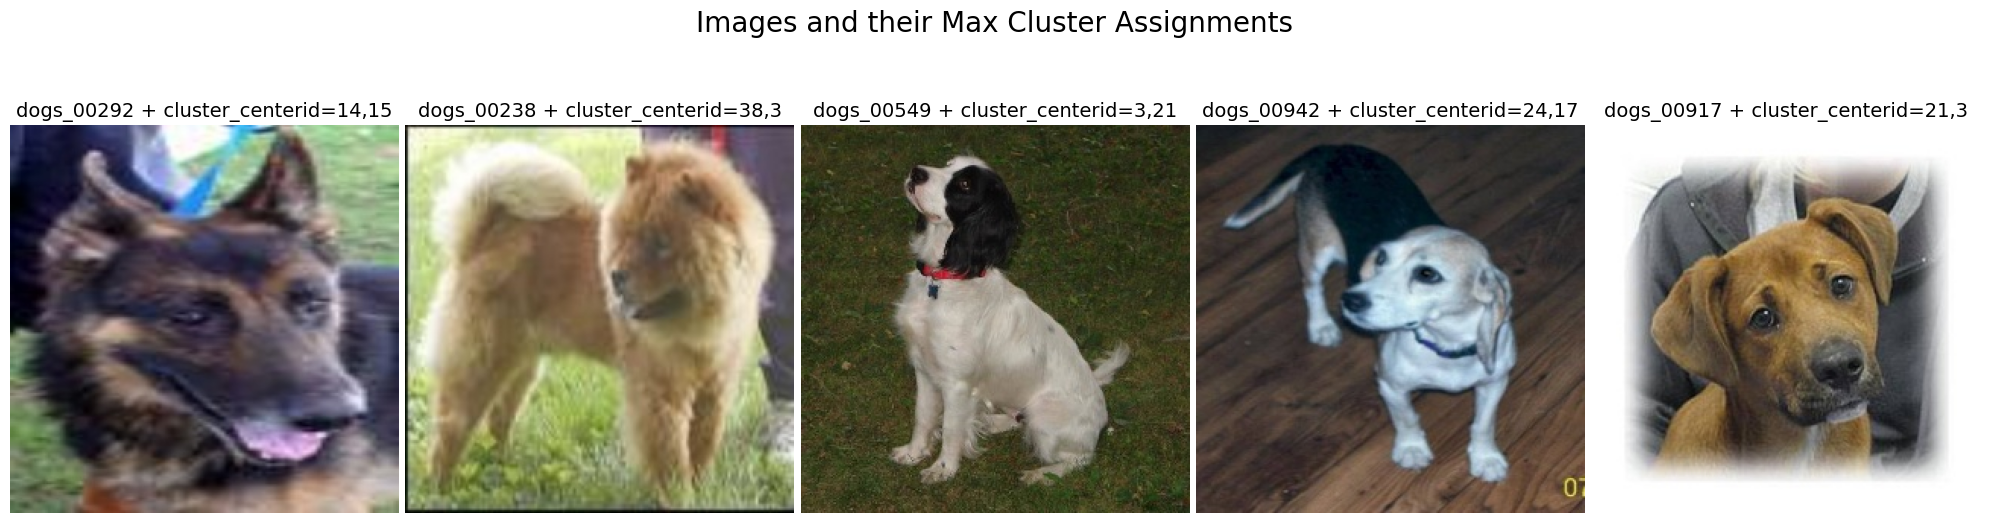

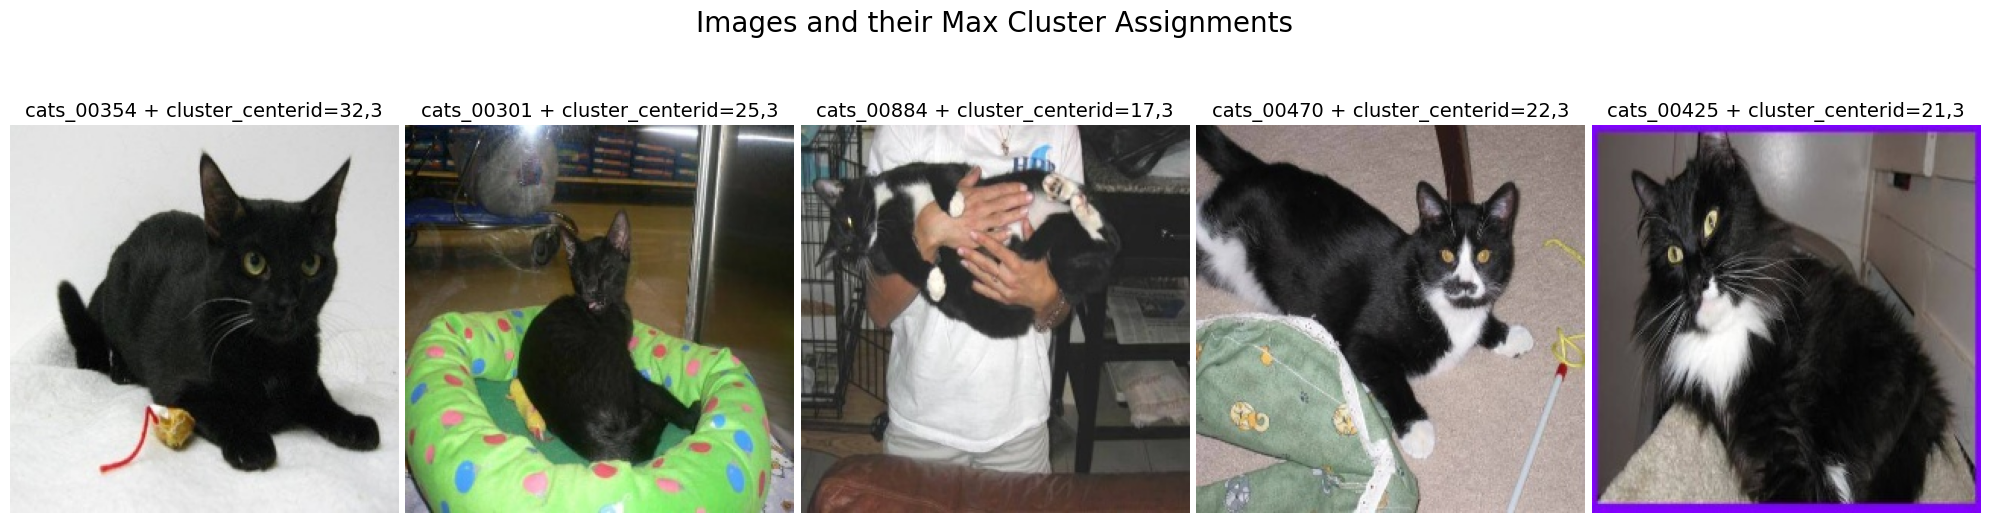

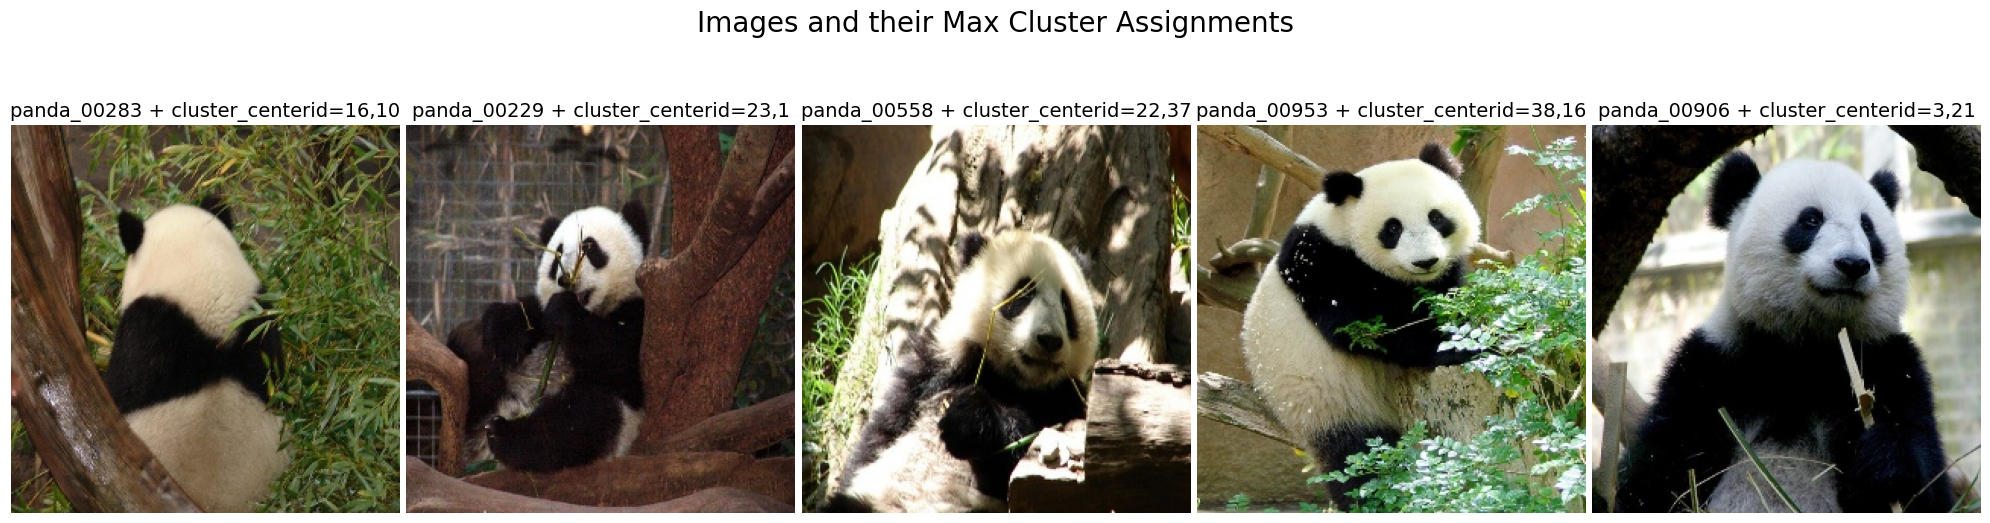

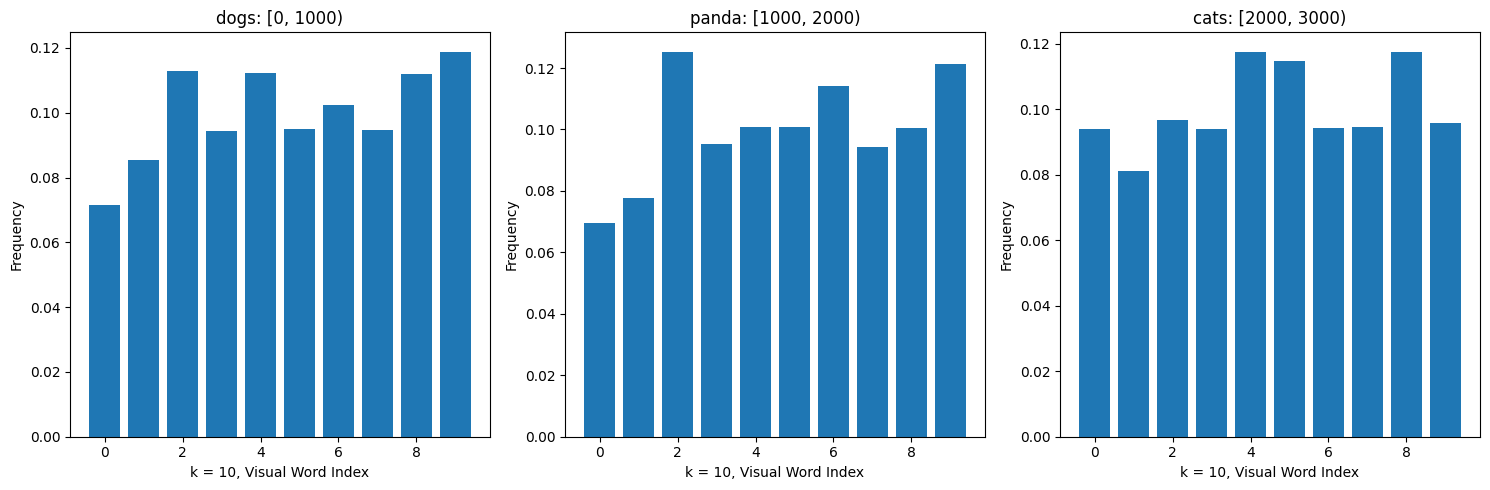

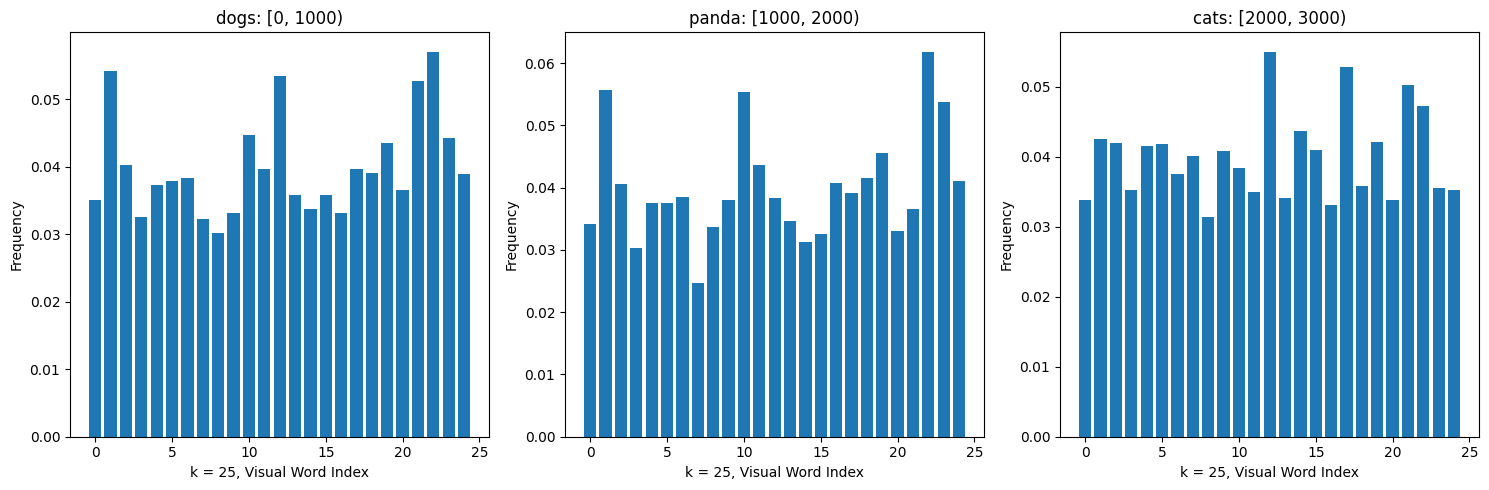

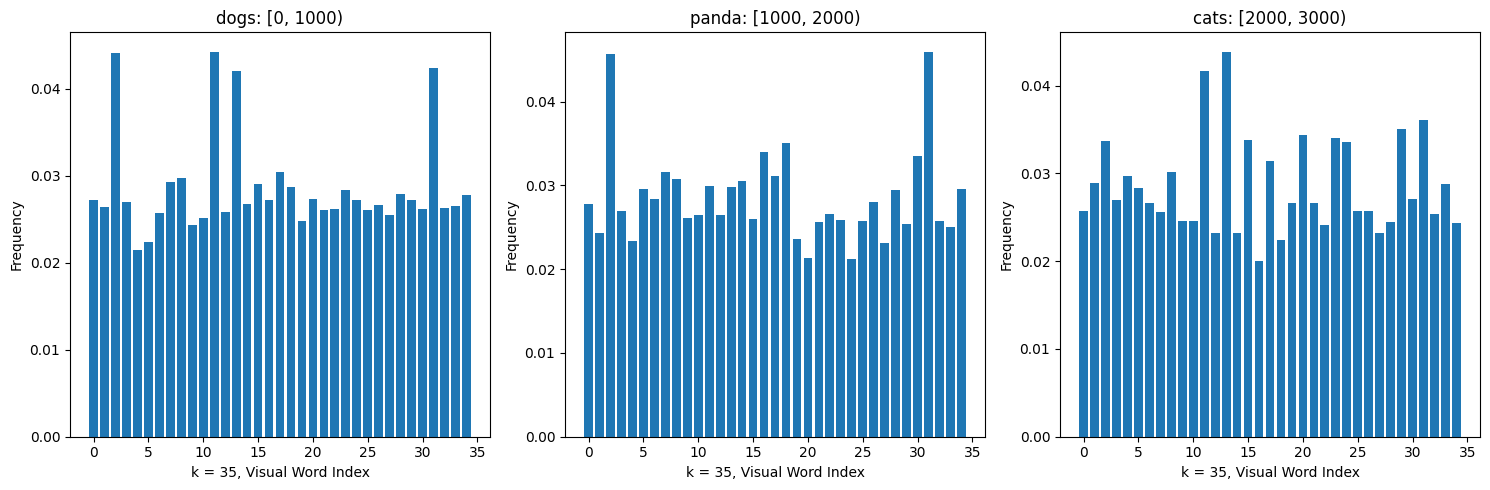

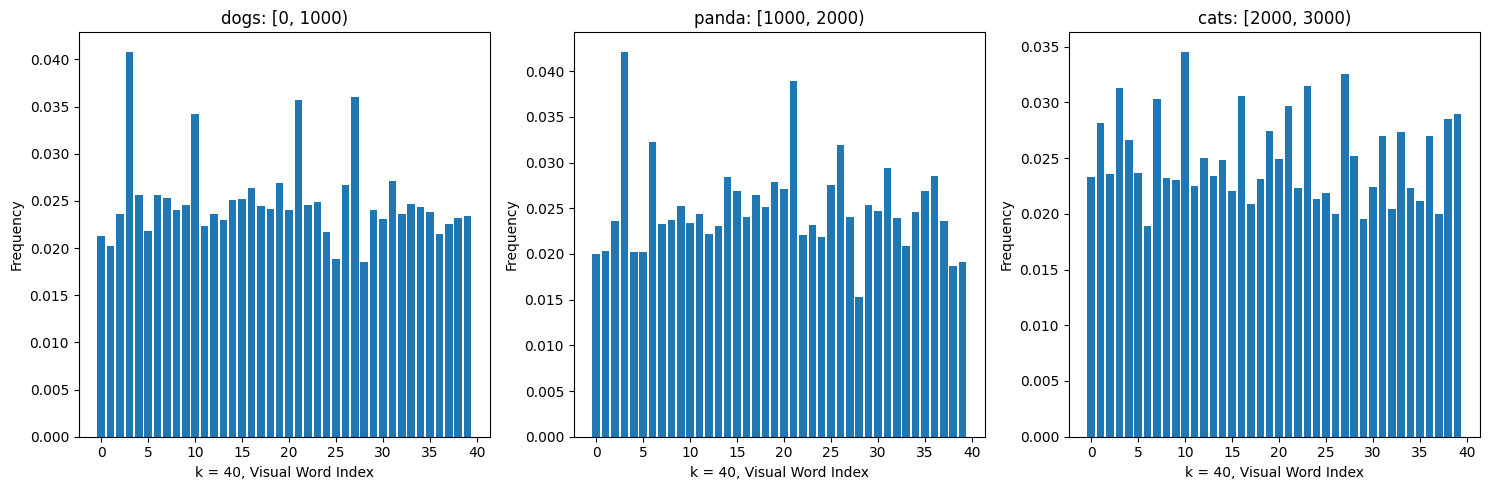

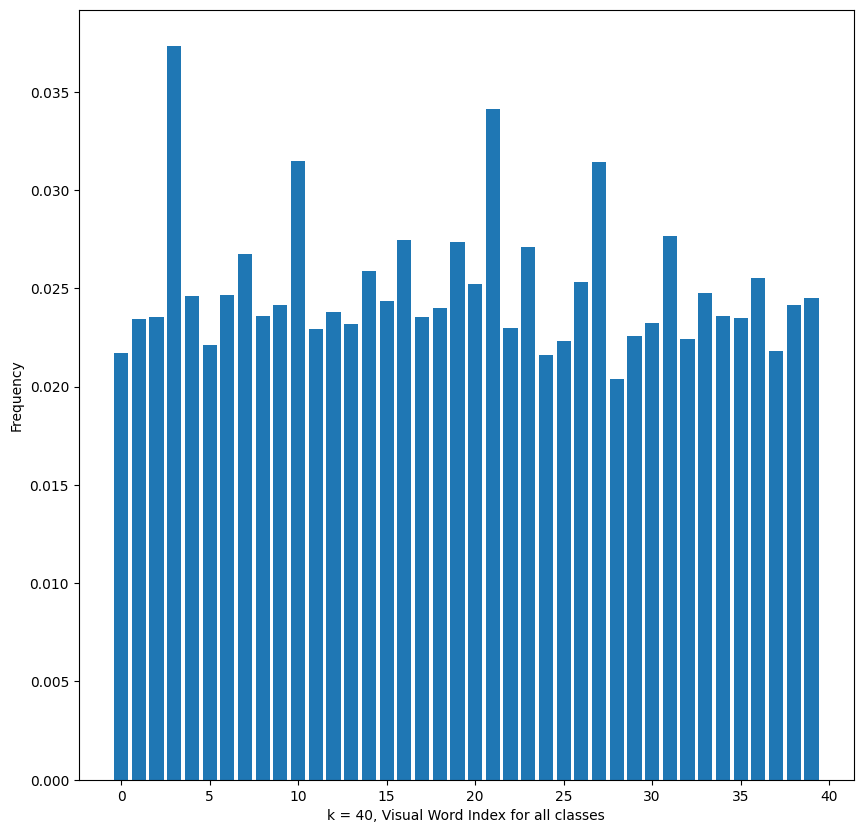

In [5]:
def visualize_classes(cluster_counts,names,nums):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
    fig.suptitle('Images and their Max Cluster Assignments', fontsize=20)

    for ax, num in zip(axs.flat, nums):
        name = os.path.basename(names[num]).replace("_features.npy", "")
        max_cluster = np.argpartition(cluster_counts[num], -2)[-2:]
        
        img = cv2.imread(names[num].replace("_features.npy", ".jpg"))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img_rgb)
        ax.set_axis_off()
        ax.set_title(f"{name} + cluster_centerid={max_cluster[0]},{max_cluster[1]}", fontsize=14)

    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    plt.show()
    
# visualize_classes(kmeans_cluster_counts_10,names,[0,1,2,3,4])
# visualize_classes(kmeans_cluster_counts_10,names,[1000,1001,1002,1003,1004])
# visualize_classes(kmeans_cluster_counts_10,names,[2000,2001,2002,2003,2004])
# visualize_classes(kmeans_cluster_counts_20,names,[0,1,2,3,4])
# visualize_classes(kmeans_cluster_counts_20,names,[1000,1001,1002,1003,1004])
# visualize_classes(kmeans_cluster_counts_20,names,[2000,2001,2002,2003,2004])
visualize_classes(kmeans_cluster_counts_40,names,[0,1,2,3,4])
visualize_classes(kmeans_cluster_counts_40,names,[1000,1001,1002,1003,1004])
visualize_classes(kmeans_cluster_counts_40,names,[2000,2001,2002,2003,2004])


def plot_cluster_counts(cluster_counts, k_value, ranges, categories):
    fig, axs = plt.subplots(1, len(ranges), figsize=(15, 5))
    
    for i, (start_index, end_index) in enumerate(ranges):
        x_scalar = np.arange(k_value)
        y_scalar = np.array([np.sum(cluster_counts[start_index:end_index, h], dtype=np.int32) for h in range(k_value)])
        axs[i].bar(x_scalar, y_scalar/np.sum(y_scalar))
        axs[i].set_xlabel(f"k = {k_value}, Visual Word Index")
        axs[i].set_ylabel("Frequency")
        axs[i].set_title(f"{categories[i]}: [{start_index}, {end_index})")

    plt.tight_layout()
    plt.show()


ranges = [(0, 1000), (1000, 2000), (2000, 3000)]
categories = ['dogs', 'panda', 'cats']


plot_cluster_counts(kmeans_cluster_counts_10, 10, ranges, categories)
plot_cluster_counts(kmeans_cluster_counts_25, 25, ranges, categories)
plot_cluster_counts(kmeans_cluster_counts_35, 35, ranges, categories)
plot_cluster_counts(kmeans_cluster_counts_40, 40, ranges, categories)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
x_scalar = np.arange(40)
y_scalar = np.array([np.sum(kmeans_cluster_counts_40[:, h], dtype=np.int32) for h in range(40)])
axs.bar(x_scalar, y_scalar/np.sum(y_scalar))
axs.set_xlabel(f"k = 40, Visual Word Index for all classes")
axs.set_ylabel("Frequency")

plt.show()

### Problem 2

(1) Implement an SVM classifier with hinge loss.

In [6]:
#get ylabel
def get_y_label(names):
    y_label = []
    for name in names:
        if "dogs" in name:
            y_label.append(0)
        elif "panda" in name:
            y_label.append(1)
        else:
            y_label.append(2)
    return y_label
y_label = get_y_label(names)
# print(y_label)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(kmeans_cluster_counts_40, y_label, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = LinearSVC(loss='hinge', random_state=30, dual=True)

(2) Train your model with the extracted BoW features and try to improve the performance

SVM

In [8]:
param_distributions = {'C': uniform(0.1, 1.0),
                       'max_iter': randint(300000, 500000)}

# Random search cross-validation for svm
random_search = RandomizedSearchCV(svm_classifier, param_distributions, cv=StratifiedKFold(5), n_iter=45, random_state=62, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)

best_svm_classifier = random_search.best_estimator_
# test set
best_svm_classifier.fit(X_train_scaled, y_train)
y_pred = best_svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Best parameters found:  {'C': 0.9864141351799908, 'max_iter': 362885}
Accuracy: 0.57


PCA

In [9]:
pca = PCA()
param_distributions_pca = {
    'n_components': randint(2, 40)  # Number of PCA components
}

# Random search cross-validation for PCA
random_search_pca = RandomizedSearchCV(pca, param_distributions_pca, cv=StratifiedKFold(5), n_iter=15, random_state=63, n_jobs=-1)
random_search_pca.fit(X_train_scaled, y_train)

print("Best PCA parameters found: ", random_search_pca.best_params_)

best_pca = random_search_pca.best_estimator_
X_train_pca = best_pca.transform(X_train_scaled)
X_test_pca = best_pca.transform(X_test_scaled)


# test set
best_svm_classifier.fit(X_train_pca, y_train)
y_pred = best_svm_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Best PCA parameters found:  {'n_components': 29}
Accuracy: 0.5383333333333333


For SVM:

A parameter distribution is defined for the SVM's regularization parameter `C` and `maximum iterations`.
Another `RandomizedSearchCV` is performed to find the best SVM parameters using the PCA-transformed training data `X_train_pca`.

For PCA:

The number of PCA components is chosen randomly between 2 and 40 using `randint(2, 40)`.
A `RandomizedSearchCV` is performed to find the best PCA parameters.
The training data is transformed using the best_pca estimator to obtain `X_train_pca` and `X_test_pca`.

Comparing the effects of using PCA versus not using PCA:

The code shows that after applying PCA dimensionality reduction, the accuracy of the SVM classifier is 0.52, which is slightly lower than the accuracy of 0.57 when not using PCA.

There could be a few potential reasons why using PCA resulted in a slightly lower accuracy in this case:

- **Information loss from dimensionality reduction:**
PCA transforms the original features into a new set of uncorrelated principal components.  While it aims to retain the maximum variance in the top principal components, there is still a risk of losing some discriminative information during this linear transformation.  If the discarded components contained useful information for the classification task, it could lead to a decrease in accuracy.

- **PCA assumptions violated:**
PCA makes certain assumptions about the data, such as linearity and Gaussian distributions.  If these assumptions are violated, PCA may not be the most suitable dimensionality reduction technique.  The original features might have non-linear relationships or non-Gaussian distributions that are better preserved without applying PCA.

- **Number of principal components chosen:**
The number of principal components retained after PCA can impact the performance.  In this case, the number of components is randomly chosen between 2 and 40.  It's possible that the randomly selected number of components wasn't optimal for this particular dataset and classification problem, leading to a slight drop in accuracy.

- **Randomness in the cross-validation process:**
Since RandomizedSearchCV is used for both PCA and SVM parameter tuning, the results can be influenced by the randomly selected parameter combinations and the specific data split for cross-validation.  Different random states or cross-validation folds could lead to variations in the reported accuracy.

In [25]:
# try to imrove the model
svm_classifier = SVC(kernel='rbf', C=0.8, max_iter=500000)
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6116666666666667


(3) Explain the backward pass in the training of the SVM classifier.

The goal of unconstrained problem of SVM is 
$$min_w \frac{1}{2}\|w\|^2 + C\sum_{i=1}^m(1-y_iw^{T}x_i)$$
1. To enhance the SVM classifier, our main focus is optimizing the parameter values represented by `w`, which define the decision boundary.
2. The first part of the objective function is the regularization term, which encourages the model to have smaller parameter values to prevent overfitting and maintain simplicity. It is represented as: 
$$R = min_w \frac{1}{2}\|w\|^2$$
&emsp;&emsp;The gradient of the regularization term with respect to `w` is:
$$\frac{\partial{R}}{\partial{w}} = w$$
3. The second part is the loss function term, which measures the classification error and penalizes misclassifications. It is represented as:
$$L = C\sum_{i=1}^m (1 - y_iw^{T}x_i)$$
&emsp;&emsp;Here, `C` is the regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error.
&emsp;&emsp;The gradient of the loss function with respect to `w` is:
$$\frac{\partial{L}}{\partial{w}} = -C\sum_{i=1}^m y_i x_i$$
4. The total gradient is the sum of the gradients of the regularization and loss terms:
$$\frac{\partial{J}}{\partial{w}} = \frac{\partial{R}}{\partial{w}} + \frac{\partial{L}}{\partial{w}}$$
5. Finally, we update the parameter 'w' using gradient descent to minimize the overall loss:
$$w = w - \alpha \frac{\partial{J}}{\partial{w}}$$
&emsp;&emsp;Here, `α` represents the learning rate, determining the size of the steps taken during the optimization process. Adjusting the learning rate is crucial for ensuring convergence and stability during training.